# Primeiro Projeto de Inteligência Artificial

*   Inteligência Artificial - Classificação

*   Felipe Daniel Dias dos Santos - 11711ECP004

*   Graduação em Engenharia de Computação - Faculdade de Engenharia Elétrica - Universidade Federal de Uberlândia

## Importação das bibliotecas

In [ ]:
#Importando as bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from scipy import stats
from sklearn import datasets
from sklearn.utils import resample
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

## Módulo HP

Obtenção do classificador Heterogeneous Pooling através dos métodos fit e predict

In [ ]:
#Classificador Heterogeneous Pooling
class HPClassifier(BaseEstimator):

    #Inicialização do HP
    def __init__(self, n_samples = None):
        
        super().__init__()
        self.n_samples = n_samples
        self.resample_random_state = -1
        self.classes_count = None
    
    #Método fit do HP
    def fit(self, x_train, y_train):
        
        #Ordenando o vetor de classes de maneira decrescente em relação à frequência
        self.classes_count = Counter(y_train).most_common()
        
        #Os classificadores serão armazenados em uma lista
        classifiers = []

        #Colocando a matriz de características e o vetor de classes em uma única matriz
        train = np.c_[x_train, y_train]
        
        #Gerando os classificadores n vezes, onde n é a quantidade de amostras requeridas
        for i_sample in range(self.n_samples):
        
            #Na primeira iteração, a amostra utilizada é a original. Na iterações restantes, é utilizada reamostragem
            #para que, provavelmente, uma amostra distinta da original seja selecionada para a amostra da vez
            if i_sample != 0:

                #Atualizando o valor de Random State e fazendo reamostragem
                self.resample_random_state += 1
                train_sample = resample(train, random_state = self.resample_random_state)
        
                #Dividindo a matriz de treino em atributos e classes
                x_train = [t[:-1] for t in train_sample]
                y_train = [t[-1] for t in train_sample]
          
            #Gerando os classificadores K Vizinhos Mais Próximos, Árvores de Decisão e Naïve Bayes Gaussiano com a 
            #amostra da vez e armazenando na lista de classificadores
            classifiers.append(KNeighborsClassifier(n_neighbors = 1).fit(x_train, y_train))
            classifiers.append(DecisionTreeClassifier().fit(x_train, y_train))
            classifiers.append(GaussianNB().fit(x_train, y_train))

        self.__self_pred = classifiers

    #Método predict do HP
    def predict(self, x_test):
        
        #Os classificadores gerados no método fit são armazenados na variável classifiers
        classifiers = self.__self_pred
        result = []
        
        #Processando cada classificador e gerando as classes a partir do conjunto de teste e armazenando os 
        #resultados em uma lista
        y_predicts = [c.predict(x_test) for c in classifiers]
    
        #As classes geradas pelos classificadores são analisadas, armazenando o resultado de cada exemplo em uma 
        #lista e, no fim, verificando a mais votada dentre os classificadores e armazenando a mesma em uma lista 
        #de resultados, que será a classificação final
        for i_example in range(len(y_predicts[0])):

            #Armazenando a classe de um mesmo exemplo gerado por todos os classificadores
            example_classes = [y[i_example] for y in y_predicts]

            #Lista de tuplas, onde o primeiro item corresponde à classe, e o segundo, à quantidade
            example_count = Counter(example_classes).most_common()
            
            #Obtendo a maior quantidade da lista example_count
            max_qnt = max(example_count, key = lambda example_count:example_count[1])[1]
            
            #Finalmente, obtendo a lista com todas as classes com a maior quantidade de ocorrências do exemplo atual
            max_classes = [ex[0] for ex in example_count if ex[1] == max_qnt]

            #Se somente uma classe foi a mais votada, será escolhida
            if len(max_classes) == 1:

                result.append(max_classes[0])
            
            #Se uma ou mais classes empataram na maior quantidade, procura-se na base de treino original qual é a 
            #mais frequente
            else:
                
                #Com a lista classes_count ordenada decrescentemente, pode-se procurar pela primeira ocorrência de
                #alguma classe mais votada, presentes em max_classes
                for c in self.classes_count:
                
                    if c[0] in max_classes:
                        
                        result.append(c[0])
            
                        break
                
        return np.array(result)

## Módulo Tables

Exibição de tabelas (resultados e testes de hipóteses) e gráfico Boxplot

In [ ]:
#Função que plota o boxplot das acurácias obtidas dos classificadores de um base de dados
def accuracyBoxPlot(results):

    accuracy = {"Bagging": results[0]["accuracy"], 
                "AdaBoost": results[1]["accuracy"],
                "RF": results[2]["accuracy"],
                "HP": results[3]["accuracy"]}

    plot = sns.boxplot(data = pd.DataFrame(accuracy), showmeans = True).set(xlabel = "Método", ylabel = "Acurácia")
    print("\n")

In [ ]:
#Função que gera a tabela contendo as informações de média, desvio padrão e limites inferior e superior dos 
#classificadores de um base de dados
def resultsTable(results):

    table = {"Método": ["Bagging", "AdaBoost", "RF", "HP"], 
             "Média": [cl["mean"] for cl in results],
             "DP": [cl["std"] for cl in results],
             "LI": [cl["inf"] for cl in results],
             "LS": [cl["sup"] for cl in results]}

    print(pd.DataFrame(table))
    print("\n")

In [ ]:
#Função que gera a tabela pareada contendo as informações de p-values do teste t pareado e do teste não paramétrico 
#de wilcoxon dos classificadores de uma base de dados
def pValuesTable(results):

    ttest_values = []
    wilcoxon_values =[]

    #Utilizamos dois ciclos para calcular os p-values de todas as combinações dos classificadores, armazenando-os 
    #nas respectivas listas  
    for i in range(3):

        for j in range(i + 1, 4):

            _, pt = stats.ttest_rel(results[i]["accuracy"], results[j]["accuracy"])
            _, pw = stats.wilcoxon(results[i]["accuracy"], results[j]["accuracy"])

            ttest_values.append(pt)
            wilcoxon_values.append(pw)

    #Utilizando os valores calculados, configura-se a tabela pareada
    table = [["Bagging", ttest_values[0], ttest_values[1], ttest_values[2]], 
             [wilcoxon_values[0], "AdaBoost", ttest_values[3], ttest_values[4]], 
             [wilcoxon_values[1], wilcoxon_values[3], "RF", ttest_values[5]], 
             [wilcoxon_values[2], wilcoxon_values[4], wilcoxon_values[5], "HP"]]

    print(pd.DataFrame(table))
    print("\n")

## Módulo Results

Obtenção dos classificadores (treino e teste), assim como seus resultados e chamada das funções de exibição de tabelas e gráfico Boxplot

In [ ]:
#Função que recebe um classificador e uma base de dados e realiza a classificação, retornando os resultados
def getResults(classifier, data_base):

    #Extraindo as características e as classes da base de dados
    atributes = data_base.data
    classes = data_base.target

    #Parâmetros para os classificadores Bagging, AdaBoost e RandomForest
    grid = {"estimator__n_estimators": [10, 25, 50, 100]}
  
    #Parâmetros para o classificador Heterogeneous Pooling
    if type(classifier) == HPClassifier:

        grid = {"estimator__n_samples": [1, 3, 5, 7]}

    #Padronização dos dados
    scalar = StandardScaler()
    pipeline = Pipeline([("transformer", scalar), ("estimator", classifier)])

    #Busca em grade do ciclo interno de validação contendo 4 folds
    gs = GridSearchCV(estimator = pipeline, param_grid = grid, scoring = "accuracy", cv = 4)

    #Ciclo externo de teste contendo 10 folds. Serão executadas 3 rodadas de ciclos aninhados de validação e teste
    rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 36851234)

    #Obtendo os resultados, assim como sua média, desvio padrão e limites inferior e superior do intervalo de 
    #confiança a 95%
    accuracy = cross_val_score(gs, atributes, classes, scoring = "accuracy", cv = rskf)
    mean = accuracy.mean()
    std = accuracy.std()
    inf, sup = stats.norm.interval(0.95, loc = mean, scale = std / np.sqrt(len(accuracy)))

    return {"accuracy": accuracy, "mean": mean, "std": std, "inf": inf, "sup": sup}

In [ ]:
#Função que mostra os resultados em tabela de resultados, tabela de testes de hipótese e boxplot
def showResults(results):

    #Boxplot dos resultados referentes à base de dados Digits
    accuracyBoxPlot(results)

    #Tabela dos resultados referentes à base de dados Digits
    resultsTable(results)

    #Tabela dos resultados dos testes de hipóteses referentes à base de dados Digits
    pValuesTable(results)

## Módulo Main

Definição das técnicas de classificação e base de dados a serem utilizadas, assim como chamada das funções de obtenção e exibição dos resultados

In [ ]:
#Importado as bases de dados a serem utilizadas nos classificadores
data_bases = [datasets.load_digits(), datasets.load_wine(), datasets.load_breast_cancer()]

#Definindo os classificadores que serão utilizados a seguir
classifiers = [BaggingClassifier(), AdaBoostClassifier(), RandomForestClassifier(), HPClassifier()]

#Gerando os classificadores das bases de dados selecionadas e armazenando os resultados. A lista results contém os 
#resultados de cada classificador em cada base de dados, na ordem em que se encontram nas listas data_bases e 
#classifiers
results = [getResults(cl, db) for db in data_bases for cl in classifiers]

Resultados da base de dados Digits:



     Método     Média        DP        LI        LS
0    Baggin  0.953075  0.012806  0.948492  0.957657
1  AdaBoost  0.269878  0.022260  0.261912  0.277844
2        RF  0.977924  0.010811  0.974055  0.981792
3        HP  0.966801  0.012873  0.962195  0.971408


             0            1            2            3
0      Bagging  2.27019e-42  1.82782e-09  0.000151018
1  1.71918e-06     AdaBoost  2.55527e-44  6.03884e-44
2  4.18922e-06  1.70837e-06           RF  3.22912e-05
3  0.000377161  1.71809e-06  0.000256687           HP




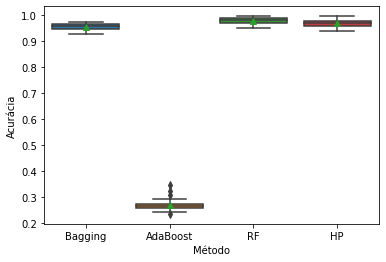

In [ ]:
#Resultados obtidos da base de dados Digits
print("Resultados da base de dados Digits:\n")
showResults(results[0:4])

Resultados da base de dados Wine:



     Método     Média        DP        LI        LS
0    Baggin  0.968083  0.053504  0.948937  0.987228
1  AdaBoost  0.912309  0.071514  0.886719  0.937900
2        RF  0.975599  0.034510  0.963250  0.987948
3        HP  0.969717  0.048413  0.952393  0.987041


            0            1            2           3
0     Bagging   0.00266301     0.259827    0.855152
1  0.00340845     AdaBoost  0.000157362  0.00109335
2    0.400381  0.000476372           RF    0.398279
3    0.904177   0.00275482     0.427263          HP




/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


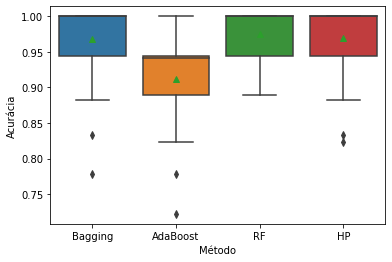

In [ ]:
#Resultados obtidos da base de dados Wine
print("Resultados da base de dados Wine:\n")
showResults(results[4:8])

Resultados da base de dados Breast Cancer:



     Método     Média        DP        LI        LS
0    Baggin  0.956662  0.026719  0.947101  0.966224
1  AdaBoost  0.967784  0.023573  0.959349  0.976219
2        RF  0.959576  0.022758  0.951432  0.967720
3        HP  0.955462  0.024315  0.946761  0.964162


            0           1          2           3
0     Bagging  0.00459345   0.347217    0.768507
1  0.00619047    AdaBoost  0.0240247  0.00496468
2    0.511003   0.0230125         RF    0.268308
3    0.913848  0.00509637   0.418584          HP




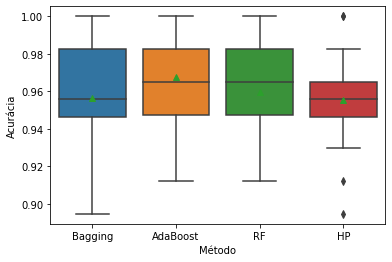

In [ ]:
#Resultados obtidos da base de dados Breast Cancer
print("Resultados da base de dados Breast Cancer:\n")
showResults(results[8:12])